In [15]:
import pickle 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
import pickle
from scipy.stats import skew,kurtosis,iqr
from ecg import ecg_feature_computation
import math
from hrvanalysis import remove_ectopic_beats
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

def get_label(user_data,st,et):
    label = 2
    for k in range(user_data.shape[0]):
        if st>=user_data[k,0] and et<=user_data[k,1]:
            label = user_data[k,2]

    return label

def get_features(a):
    features = [np.std(a),np.mean(a),np.median(a),
                np.percentile(a,75),np.percentile(a,25),iqr(a),
                skew(a),kurtosis(a),variation(a),
                len(np.where(a>0)[0]),len(np.where(a>.25)[0]),len(np.where(a>.5)[0]),len(np.where(a>.75)[0])]
    return features

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

no_of_feature = 7
# no_of_feature = 2
from scipy.stats import variation
def combine_data_sobc(feature_matrix,user_col,label_col,quality_col,heart_rate_final,label_data):
    try:
        participant = user_col[0]
        feature_matrix = []
        feature_matrix_quality = []
        user_col = []
        label_col = []
        quality_col = []
        heart_rate_final = heart_rate_final[heart_rate_final[:,2]>.05]
        ts_array = np.arange(heart_rate_final[0,0],heart_rate_final[-1,0],60000)
        for t in ts_array:
            index = np.where((heart_rate_final[:,0]>=t-30000)&(heart_rate_final[:,0]<t+30000))[0]
            if len(index)<30:
                continue
            heart_rate_window = heart_rate_final[index]
            if np.median(heart_rate_window[:,2])<.1:
                continue
            label = get_label(label_data,t-20000,t+20000)
            try:
                r,tt = weighted_avg_and_std(heart_rate_window[heart_rate_window[:,2]>.25,1],heart_rate_window[heart_rate_window[:,2]>.25,2])
            except:
                continue
            index = np.where((heart_rate_window[:,1]<r+3*tt)&(heart_rate_window[:,1]>r-3*tt))[0]
            heart_rate_window = heart_rate_window[index]
            if len(index)<30:
                continue
            feature = ecg_feature_computation(heart_rate_window[:,0],
                                              heart_rate_window[:,1])
            feature_quality = get_features(heart_rate_window[:,2])
            feature_matrix.append(np.array(feature).reshape(-1,no_of_feature))
            feature_matrix_quality.append(np.array(feature_quality).reshape(-1,13))
            user_col.append(participant)
            label_col.append(label)
            quality_col.append(np.median(heart_rate_window[:,2]))
        return np.array(feature_matrix).reshape(-1,no_of_feature),user_col,label_col,quality_col,heart_rate_final,np.array(feature_matrix_quality).reshape(-1,13)
    except Exception as e:
        print(e)
        return np.zeros((0,no_of_feature)),[],[],[],[],np.array([])

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=30)]: Done  28 out of  72 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=30)]: Done  43 out of  72 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  58 out of  72 | elapsed:    1.9s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  72 out of  72 | elapsed:    2.0s finished


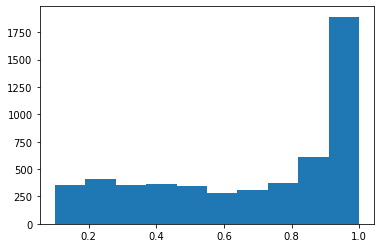

(3253, 7) (3253, 13) 3253 724 3253 3253 32


In [18]:
final_data = pickle.load(open('../data_users/data_sobc_25_secs.p','rb'))
final_output = Parallel(n_jobs=30,verbose=5)(delayed(combine_data_sobc)(*a) for a in final_data)
X = np.zeros((0,no_of_feature))
X_qual = np.zeros((0,13))
y = []
groups = []
qual = []
for m in final_output:
    feature_matrix,user_col,label_col,quality_col,hr,quals = m
    if len(feature_matrix)<2:
        continue
#     print(quals.shape)
    tmp = StandardScaler().fit_transform(feature_matrix)
    X = np.concatenate((X,tmp))
    X_qual = np.concatenate((X_qual,quals))
    y.extend(label_col)
    groups.extend(user_col)
    qual.extend(quality_col)

plt.hist(qual)
plt.show()
from sklearn import linear_model
def get_only_stress_no_stress(X,groups,y,qual,X_qual):
    y = np.int64(y)
    index = np.where(y<2)[0]
    X,groups,y,qual,X_qual = X[index,:],groups[index],y[index],qual[index],X_qual[index]
    ind = []
    not_wanted = ['ae1238c0-6146-491b-b199-ead784386c5b',
                 'bb3e2113-ca54-4f36-9ecf-d5fff354521f']
    for grp in np.unique(groups):
        if grp in not_wanted:
            continue
        tmp = np.where(groups==grp)[0]
        if len(np.unique(y[tmp]))>1:
            ind.extend(list(tmp))
    ind = np.int64(np.array(ind))
    return X[ind],y[ind],groups[ind],qual[ind],X_qual[ind]
y = np.array(y)
groups = np.array(groups)
y = y[~np.isnan(X).any(axis=1)]
groups = groups[~np.isnan(X).any(axis=1)]
X_qual = X_qual[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]

y = y[~np.isinf(X).any(axis=1)]
qual = np.array(qual)
qual = qual[~np.isinf(X).any(axis=1)]
groups = groups[~np.isinf(X).any(axis=1)]
X = X[~np.isinf(X).any(axis=1)]
X_qual = X_qual[~np.isinf(X).any(axis=1)]

X,y,groups,qual,X_qual = get_only_stress_no_stress(X,groups,y,qual,X_qual)
print(X.shape,X_qual.shape,len(y),len(y[y==1]),len(groups),len(qual),len(np.unique(groups)))

In [51]:
from pprint import pprint
from sklearn.metrics import f1_score,classification_report,precision_recall_curve
from sklearn.model_selection import ParameterGrid, GroupKFold
from keras.layers import Dense,Input,Flatten,TimeDistributed,merge,multiply
from keras.models import Model


def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = precision_recall_curve(y, probs)
    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def get_model(input_dims=7):
    inputs = Input(shape=(input_dims,))
    input1 = Dense(input_dims,activation='sigmoid')(inputs)
    attention_probs = Dense(input_dims, activation='softmax', name='attention_probs')(input1)
#     attention_mul = merge([input1, attention_probs], name='attention_mul', mode='mul')
    attention_mul = multiply([input1, attention_probs])
#     encoded = Flatten()(attention_mul)
    output = Dense(1,activation='sigmoid')(attention_mul)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    return model
    
def get_predictions(train_index,test_index,X,y,X_qual,groups):
    X_train,X_test,y_train,\
    y_test,groups_train,groups_test,\
    X_qual_train,X_qual_test= X[train_index],X[test_index],y[train_index],\
    y[test_index],groups[train_index],groups[test_index],X_qual[train_index],X_qual[test_index]
    model = get_model()
    model.fit(X_train,y_train,epochs=40,validation_split=.2,verbose=0,batch_size=20)
    preds = model.predict(X_test).reshape(-1)
    f,b = f1Bias_scorer_CV(preds, y_test, ret_bias=True)
    print(f,b)
    return preds.reshape(-1),y_test.reshape(-1)
    
def get_f1(X,X_qual,y,groups):
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    yss = []
    predss = []
    output = [get_predictions(train_index,test_index,X,y,X_qual,groups) for train_index,test_index in gkf.split(X,y,groups=groups)]
    for a,b in output:
        yss.extend(list(b))
        predss.extend(list(a))
    print(f1Bias_scorer_CV(predss, yss, ret_bias=True))
get_f1(X,X_qual,y,groups)

0.7605633802816902 0.26251388
0.8979591836734694 0.6950942
0.7272727272727274 0.50074166
0.8181818181818182 0.45698127
0.7586206896551724 0.22043686
0.6829268292682926 0.51338744
0.28 0.053060796
0.8333333333333333 0.35109654
0.7999999999999999 0.69473934
0.9032258064516129 0.6046673
0.6122448979591836 0.4142043
0.6250000000000001 0.39424834
0.5925925925925926 0.33428636
0.6470588235294117 0.50765043
0.721311475409836 0.21747722
0.8666666666666666 0.4710872
0.888888888888889 0.27328107
0.6913580246913581 0.07112677
0.71875 0.10631876
1.0 0.41949287
0.7500000000000001 0.25645074
0.8571428571428571 0.12198852
0.6197183098591549 0.10665767
0.6909090909090909 0.1441175
0.8125 0.3474235
0.5333333333333333 0.46136984
0.8421052631578948 0.42955038
0.6567164179104478 0.081932
0.9565217391304348 0.33015814
0.9090909090909091 0.13785283
0.6956521739130435 0.20140797
0.8461538461538461 0.52947766
(0.6623207301173403, 0.30567464)
